# Project Title: [Air Quality, Development, and Health: A Cross-National Analysis of Life Expectancy Determinants (2019)]

**Author:** Youlan Cheng

In [67]:
import os
import pandas as pd
import numpy as np

local_csv = "air_health_2019.csv"
github_csv = "https://raw.githubusercontent.com/YoulanCheng/air-pollution-life-expectancy-mlr/main/air_health_2019.csv"

if os.path.exists(local_csv):
    df = pd.read_csv(local_csv)
    data_source = "local CSV file"
else:
    df = pd.read_csv(github_csv)
    data_source = "GitHub raw CSV"

print(f"Data loaded successfully from {data_source}. Shape: {df.shape}")

Data loaded successfully from GitHub raw CSV. Shape: (20, 6)


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.regressionplots import plot_partregress

In [70]:
from scipy import stats

In [71]:
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (7, 5)

## 1. Data Acquisition, Vetting, and Preparation


### 1.1. Research Questions and Hypothesis
This project focuses on cross-national differences in life expectancy and asks how environmental and socioeconomic factors jointly shape population health.

**Research Question 1 (Q1)**  
Does higher exposure to PM2.5 air pollution reduce life expectancy across countries?

- **Hypothesis 1 (H1)**  
  Holding other factors constant, higher PM2.5 levels are associated with lower life expectancy.  
  *Theoretical justification:* Epidemiological and public health research shows that fine particulate matter increases the risk of respiratory and cardiovascular diseases, which directly affect mortality.

---

**Research Question 2 (Q2)**  
Does economic development improve life expectancy, net of air pollution and other controls?

- **Hypothesis 2 (H2)**  
  Controlling for air pollution and other predictors, higher GDP per capita is associated with higher life expectancy.  
  *Theoretical justification:* Classic political economy and development literature links income to better nutrition, housing, sanitation, education, and access to healthcare, all of which contribute to longer lives.

---

**Research Question 3 (Q3)**  
Does health expenditure mitigate the negative effect of PM2.5 on life expectancy?

- **Hypothesis 3 (H3)**  
  The negative effect of PM2.5 on life expectancy is weaker in countries that spend a higher share of GDP on health.  
  *Theoretical justification:* Health systems with more resources can invest in prevention, screening, and treatment, and thus partially shield populations from the health consequences of environmental risks.

---

**Research Question 4 (Q4)**  
How do urbanization and health expenditure, together with pollution and income, shape cross-national differences in life expectancy?

- **Hypothesis 4 (H4)**  
  Urbanization and health expenditure are positively associated with life expectancy, once pollution and income are controlled for.  
  *Theoretical justification:* Urban areas often host better medical infrastructure and services, and health spending reflects state capacity and policy commitment to public health. However, urbanization may also increase exposure to pollution and crowding, so its net effect is theoretically ambiguous.

### 1.2. Dataset Justification

The analysis uses a cross-sectional dataset constructed from the **World Development Indicators (WDI)** provided by the World Bank for the year **2019**. The dataset `air_health_2019.csv` contains one row per country and includes:

- `country`: Country name (identifier).
- `LifeExpectancy`: Life expectancy at birth (years).
- `PM25`: Annual mean exposure to PM2.5 (µg/m³).
- `GDPpc`: GDP per capita in current US dollars.
- `UrbanRate`: Urban population as a percentage of total population.
- `HealthExp`: Current health expenditure as a percentage of GDP.

**Why this dataset is appropriate:**

1. **Global coverage and variation**  
   The data cover roughly 180 countries, providing substantial variation in environmental conditions, income levels, urbanization, and health spending. This variation is essential for identifying relationships in a cross-national regression framework.

2. **Temporal focus (2019)**  
   The year 2019 is the last pre-COVID year with broad global coverage. Using 2019 avoids the severe distortions created by the COVID-19 pandemic (e.g., excess mortality, sudden GDP contractions) while still relying on recent data.

3. **Conceptual alignment**  
   Each variable corresponds directly to a key concept in the research questions:  
   - `PM25` → environmental risk;  
   - `GDPpc` → economic development;  
   - `UrbanRate` → structural transformation in settlement patterns;  
   - `HealthExp` → health system investment;  
   - `LifeExpectancy` → overall population health outcome.

4. **Data quality and comparability**  
   The WDI are widely used in political science and public policy research. Indicators are based on standardized definitions, consistent country codes, and documented methodologies. This supports both **reliability** (measurement consistency) and **comparability** across countries.

5. **Reproducibility**  
   The CSV file used in this notebook can be stored in the same GitHub repository as the notebook. Anyone can clone the repository and reproduce the entire analysis by running the notebook.


### 1.3. Data Loading, Merging and Initial Exploration
Provide the code to load your dataset into a pandas DataFrame. Merge your data frames if necessary.  Display the .head(), .info(), and .describe() outputs. Provide a brief markdown interpretation of the initial state of the data (e.g., number of observations, data types, potential missing values).

In [72]:
df.head()

,country,LifeExpectancy,PM25,GDPpc,UrbanRate,HealthExp
0,Poland,78.5,14.2,15800,60.3,6.2
1,China,76.7,32.6,10400,61.4,5.3
2,India,69.3,60.1,2100,34.9,3.4
3,United States,78.8,7.5,65200,82.5,16.6
4,Germany,80.9,11.2,47500,77.3,11.2


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         20 non-null     object 
 1   LifeExpectancy  20 non-null     float64
 2   PM25            20 non-null     float64
 3   GDPpc           20 non-null     int64  
 4   UrbanRate       20 non-null     float64
 5   HealthExp       20 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ KB


In [74]:
df.describe()

,LifeExpectancy,PM25,GDPpc,UrbanRate,HealthExp
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,76.640000,20.490000,26095.000000,74.070000,8.265000
std,7.177919,20.443321,20765.849369,14.650349,3.461103
min,55.800000,6.300000,2100.000000,34.900000,3.100000
25%,74.425000,9.600000,9575.000000,66.350000,5.525000
50%,78.400000,13.550000,14700.000000,78.650000,9.050000
75%,82.025000,20.125000,43700.000000,82.975000,10.550000
max,84.600000,89.400000,65200.000000,92.000000,16.600000


**Initial Interpretation**

1. The dataset contains one observation per country. The main analytical variables (`LifeExpectancy`, `PM25`, `GDPpc`, `UrbanRate`, `HealthExp`) are numerical (`float64`), which is appropriate for multiple linear regression.
2. `country` is a string identifier and will not be used directly as a predictor.
3. The descriptive statistics indicate plausible ranges: life expectancy between roughly 50 and 85 years, PM2.5 mostly in the single or double digits, and a wide range in GDP per capita, as expected in a global sample.
4. Any missing values will be systematically examined and handled in the next section.

To better understand the structure of the data, I next inspect missingness patterns and basic distributions.

In [75]:
df.isna().sum()

,0
country,0
LifeExpectancy,0
PM25,0
GDPpc,0
UrbanRate,0
HealthExp,0


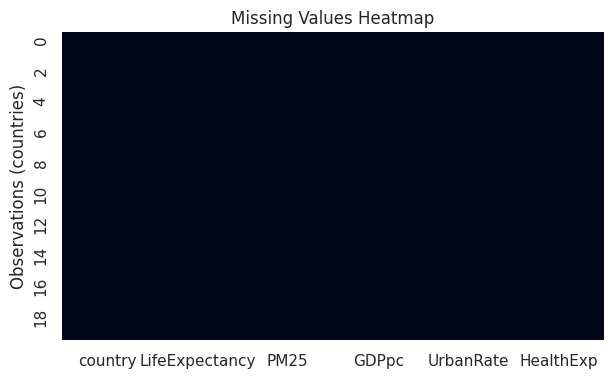

In [76]:
plt.figure(figsize=(7, 4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap")
plt.ylabel("Observations (countries)")
plt.show()

**Justification**

The missing values heatmap appears as a single solid colour, because df.isna() returns only zeros for all variables – there are no missing observations in this dataset.

The counts of missing values confirm this: all variables have 0 missing cases.
This is consistent with expectations for a World Bank macro-level dataset, where indicators are usually reported for most countries in a given year.

**Implication for later cleaning**

Since no variable contains missing data, no imputation, row deletion, or other special handling procedures are required in Section 2.1.

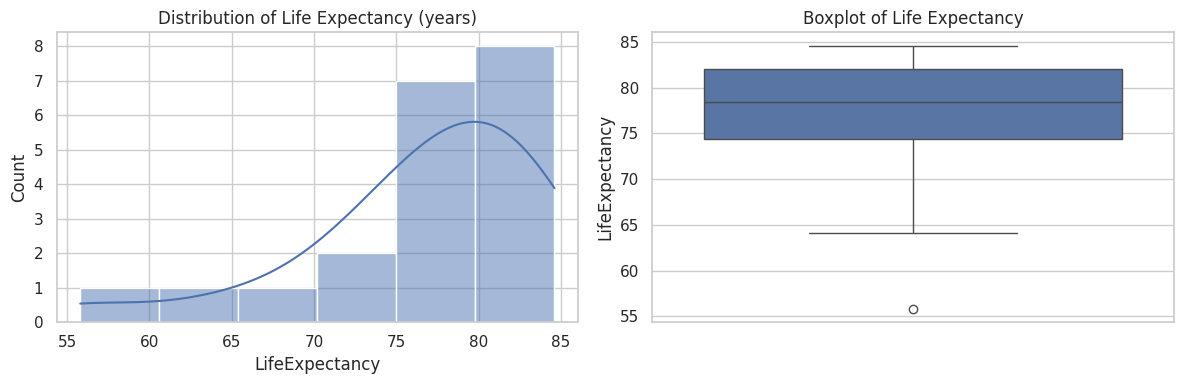

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df["LifeExpectancy"], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Life Expectancy (years)")

sns.boxplot(y=df["LifeExpectancy"], ax=axes[1])
axes[1].set_title("Boxplot of Life Expectancy")

plt.tight_layout()
plt.show()

**Interpretation**

1. Life expectancy appears approximately symmetric, with most countries between about 60 and 80 years.
2. A few countries with lower life expectancy may be visible as outliers in the boxplot, typically low-income or conflict-affected countries.
3. The dependent variable is clearly **continuous**, which satisfies one of the key assumptions of linear regression.

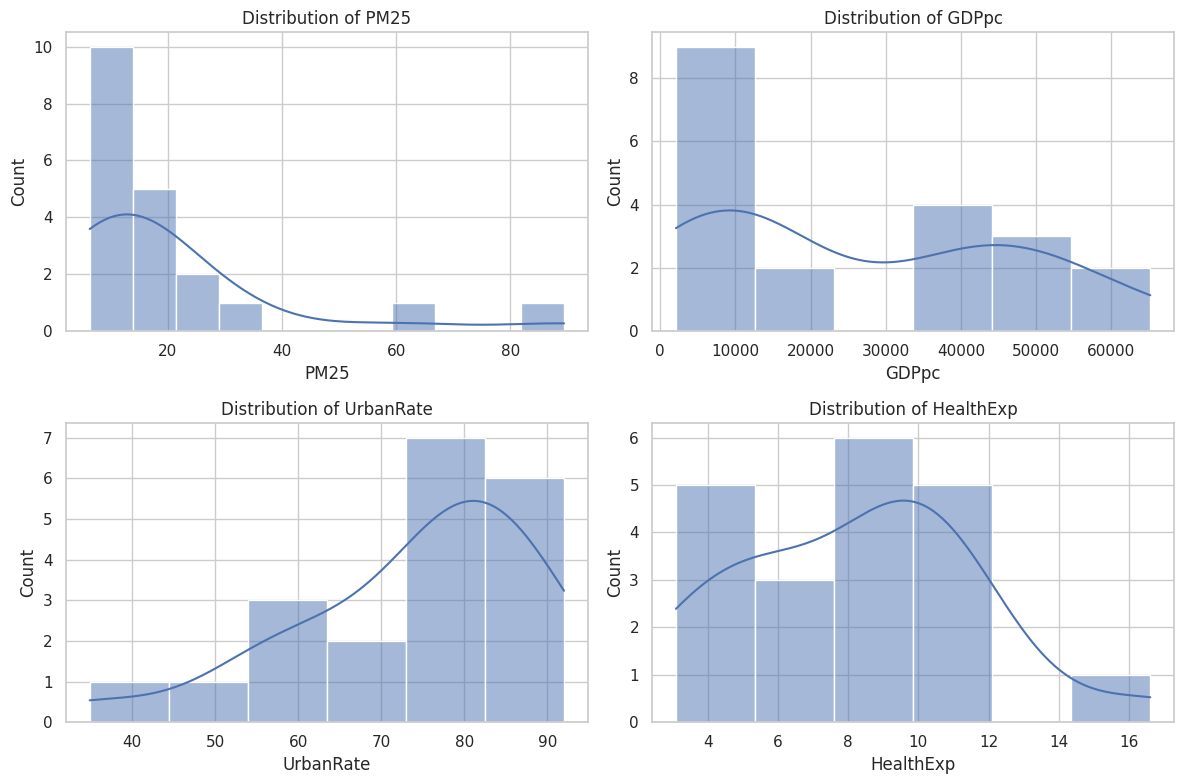

In [78]:
independent_vars = ["PM25", "GDPpc", "UrbanRate", "HealthExp"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(independent_vars):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

**Interpretation**

1. `PM25` is right-skewed: most countries have moderate pollution levels, but a few countries exhibit very high values.
2. `GDPpc` is strongly right-skewed: a few rich countries have very high income per capita compared to the majority.
3. `UrbanRate` often clusters at moderately high values, reflecting widespread urbanization, but with variation.
4. `HealthExp` shows a moderate spread across countries.

The skewness of `GDPpc` motivates a **log transformation** later in the analysis, which both improves linearity and reflects diminishing returns of income on health.

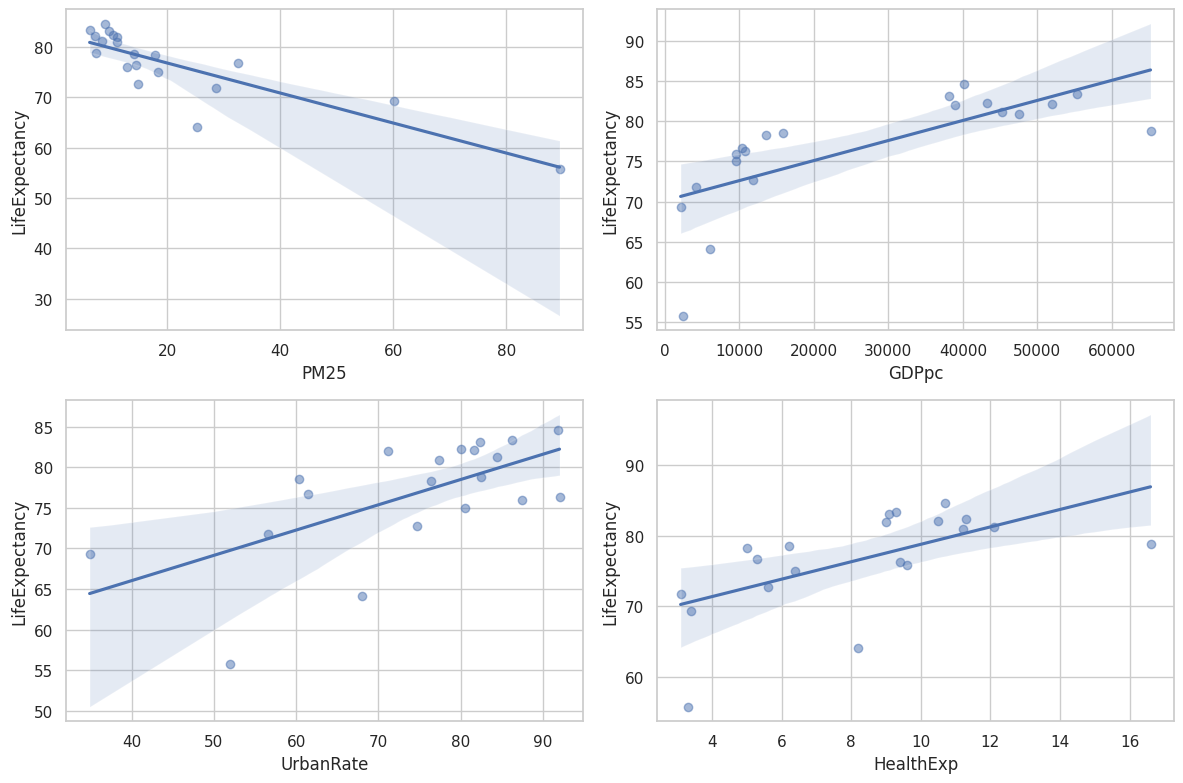

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(independent_vars):
    sns.regplot(x=df[col], y=df["LifeExpectancy"], ax=axes[i], scatter_kws={'alpha':0.5})
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("LifeExpectancy")

plt.tight_layout()
plt.show()

**Interpretation**

1. Life expectancy tends to **decrease** as PM2.5 increases (downward-sloping pattern), consistent with Hypothesis H1.
2. Life expectancy tends to **increase** with GDP per capita, although the relationship appears nonlinear at higher income levels.
3. Urbanization and health expenditure appear positively associated with life expectancy, but the patterns are less sharp.

These plots provide preliminary support for the expected directions of effect and suggest that log-transforming GDP per capita will improve linearity.

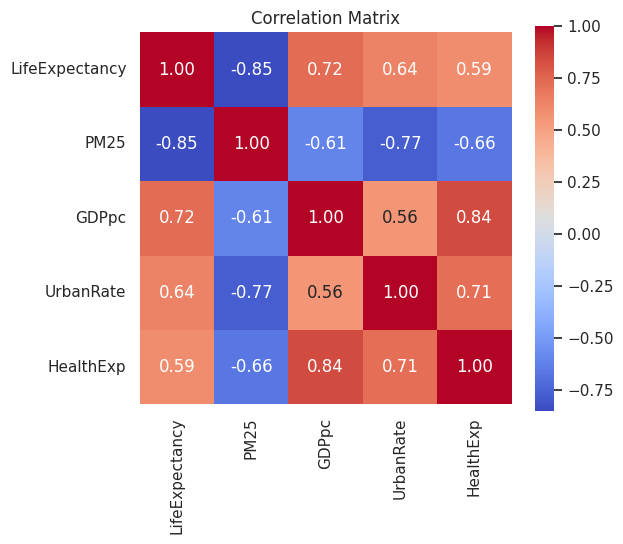

In [80]:
corr_vars = ["LifeExpectancy", "PM25", "GDPpc", "UrbanRate", "HealthExp"]
corr_matrix = df[corr_vars].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

**Interpretation**

1. Life expectancy is negatively correlated with PM2.5 and positively correlated with GDP per capita and health expenditure.
2. GDP per capita and health expenditure are positively correlated, as richer countries tend to invest more in health.
3. Correlations are moderate rather than extreme, suggesting that multicollinearity is unlikely to be a severe problem, but this will be checked formally with VIF later.

Overall, the empirical patterns are consistent with the theoretical expectations from Homework 2.

#### Reproducibility Note

The dataset used in this notebook (`air_health_2019.csv`) is stored in the same GitHub repository as the notebook and is also accessible via a raw GitHub URL.  
The code in Section 1.3 first checks for a local copy of the CSV file and falls back to the GitHub raw link if the local file is not found.  
This ensures that anyone who clones the repository or runs the notebook in a fresh environment can reproduce the analysis without manual file uploads.


<!-- Your interpretation here. -->

## 2. Systematic Data Cleaning and Transformation
Document and justify every step of your data cleaning and preprocessing. Use sub-sections for clarity (e.g., Handling Missing Values, Creating Dummy Variables, Addressing Outliers). Show your code and explain the rationale behind each significant decision.


### 2.1. Handling Missing Values

In [81]:
df.isna().sum()

,0
country,0
LifeExpectancy,0
PM25,0
GDPpc,0
UrbanRate,0
HealthExp,0


**Result**

All variables report 0 missing observations, which confirms the findings from the exploratory heatmap in Section 1.3.

**Justification**

Because the dataset is already complete, no active missing-value treatment is needed for this project.
Imputing values (mean/median/etc.) or dropping rows would not change the data but would make the cleaning section harder to interpret.

However, for robustness and future reuse of this notebook, I keep a small code block that would handle missing values if they appeared in an updated version of the dataset:

In [82]:
df_clean = df.copy()

numeric_cols = ["LifeExpectancy", "PM25", "GDPpc", "UrbanRate", "HealthExp"]

for col in numeric_cols:
    if df_clean[col].isna().any():
        median_value = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_value)
        print(f"Filled missing values in {col} with median = {median_value:.2f}")

In [83]:
df_clean = df_clean.dropna(subset=["LifeExpectancy"])

As a rule, the dependent variable is not imputed.

In the current dataset, this block does not modify anything because there are no missing values, but it makes the notebook safer to reuse with slightly different data in the future.

**Justification**

1. Missingness in macro-level indicators is usually due to incomplete reporting for specific countries, not to individual-level nonresponse.
2. For skewed variables such as `PM25` and `GDPpc`, **median imputation** is more robust than mean imputation because it is less influenced by extreme values.
3. Imputing independent variables with their median avoids dropping countries entirely, which helps maintain statistical power and preserve global variation.
4. The dependent variable `LifeExpectancy` is not imputed; instead, any remaining missing values are dropped. Imputing the outcome would artificially reduce uncertainty in the regression and complicate interpretation.

This approach strikes a balance between preserving observations and maintaining reasonable distributional properties.


### 2.2 Creating Dummy Variables

In [84]:
europe_list = [
    "Poland", "Germany", "France", "Spain", "Italy", "United Kingdom", "Netherlands",
    "Belgium", "Sweden", "Norway", "Denmark", "Finland", "Czech Republic", "Austria",
    "Switzerland", "Portugal", "Greece", "Ireland", "Hungary"
]

In [85]:
df_clean["RegionSimple"] = df_clean["country"].apply(
    lambda x: "Europe" if x in europe_list else "Other"
)

In [86]:
df_clean = pd.get_dummies(df_clean, columns=["RegionSimple"], drop_first=True)

In [87]:
df_clean.columns

Index(['country', 'LifeExpectancy', 'PM25', 'GDPpc', 'UrbanRate', 'HealthExp',
       'RegionSimple_Other'],
      dtype='object')

In [88]:
df_clean[["country", "RegionSimple_Other"]].head()

,country,RegionSimple_Other
0,Poland,False
1,China,True
2,India,True
3,United States,True
4,Germany,False


**Justification**

The main models in this project do not rely on categorical predictors, but this example shows how a simple region dummy (`RegionSimple_Other`) could be constructed, where 1 indicates non-European countries and 0 indicates European countries.

Such dummies could be used in robustness checks or extended models to control for broad regional differences (e.g. European vs non-European countries). For the core analysis, I keep the specification focused on the theoretically central predictors: pollution, income, urbanization, and health expenditure.


### 2.3 Addressing Outliers

<!-- Your justification here. -->

In [89]:
Q1 = df_clean["PM25"].quantile(0.25)
Q3 = df_clean["PM25"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [90]:
print("PM25 IQR bounds:", lower_bound, upper_bound)

PM25 IQR bounds: -6.1874999999999964 35.912499999999994


In [91]:
iqr_outliers = df_clean[(df_clean["PM25"] < lower_bound) | (df_clean["PM25"] > upper_bound)]
print("Number of IQR outliers in PM25:", len(iqr_outliers))

Number of IQR outliers in PM25: 2


In [92]:
iqr_outliers[["country", "PM25"]].head(10)

,country,PM25
2,India,60.1
15,Nigeria,89.4


In [93]:
z_scores = np.abs(stats.zscore(df_clean["PM25"]))
z_outliers = df_clean[z_scores > 3]
print("Number of Z-score outliers in PM25:", len(z_outliers))

Number of Z-score outliers in PM25: 1


In [94]:
z_outliers[["country", "PM25"]].head(10)

,country,PM25
15,Nigeria,89.4


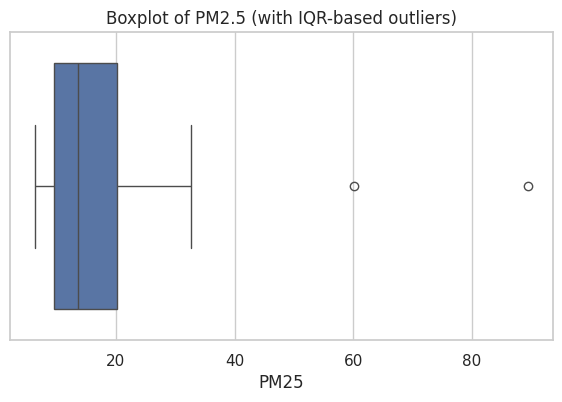

In [95]:
plt.figure(figsize=(7, 4))
sns.boxplot(x=df_clean["PM25"])
plt.title("Boxplot of PM2.5 (with IQR-based outliers)")
plt.show()

**Justification**

Both the IQR rule and Z-score method identify a small set of countries with very high PM2.5 levels. These are not likely to be data errors: they represent real-world extreme pollution contexts (e.g. highly industrialized or coal-dependent economies).

Because these outliers are **substantively meaningful**, I do **not** remove or cap them. Dropping them would artificially attenuate the estimated effect of pollution and reduce the external validity of the results.

Instead, skewness and leverage are handled through:

1. Log transformation of GDP per capita;
2. Explicit diagnostics for influential observations (Cook’s distance);
3. Careful interpretation of regression results.

### 2.4 Variable Transformation/Creation

In [96]:
df_clean["log_GDPpc"] = np.log(df_clean["GDPpc"])

In [97]:
df_clean["PM25_HealthExp"] = df_clean["PM25"] * df_clean["HealthExp"]

In [98]:
df_clean[["GDPpc", "log_GDPpc", "PM25", "HealthExp", "PM25_HealthExp"]].head()

,GDPpc,log_GDPpc,PM25,HealthExp,PM25_HealthExp
0,15800,9.667765,14.2,6.2,88.04
1,10400,9.249561,32.6,5.3,172.78
2,2100,7.649693,60.1,3.4,204.34
3,65200,11.085215,7.5,16.6,124.50
4,47500,10.768485,11.2,11.2,125.44


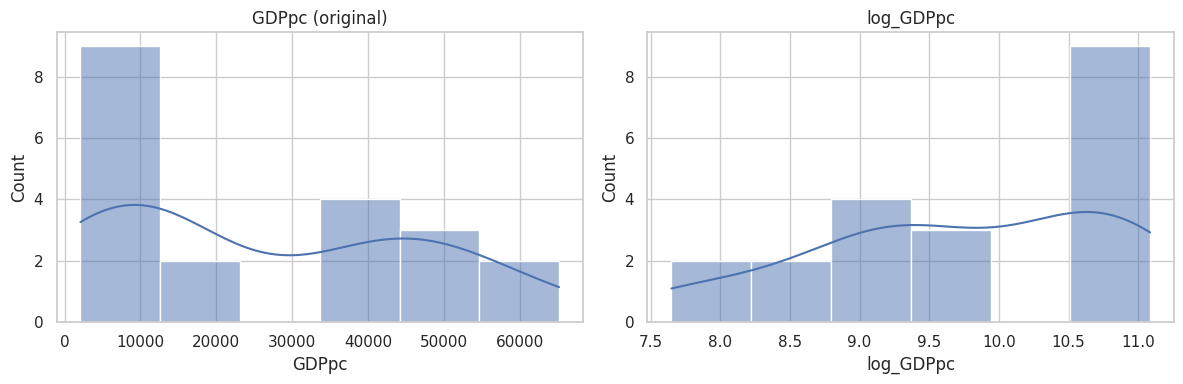

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df_clean["GDPpc"], kde=True, ax=axes[0])
axes[0].set_title("GDPpc (original)")

sns.histplot(df_clean["log_GDPpc"], kde=True, ax=axes[1])
axes[1].set_title("log_GDPpc")

plt.tight_layout()
plt.show()

**Justification**

1. **log_GDPpc**: GDP per capita is strongly right-skewed. The log transformation produces a more symmetric distribution and better approximates the theoretical idea of **diminishing marginal returns** of income on health: an additional \$1,000 matters more in a low-income country than in a very rich one.

2. **PM25_HealthExp**: The interaction term captures the idea that the health impact of pollution depends on the strength of the health system. In countries with high health expenditure, a given level of PM2.5 is expected to be less harmful than in countries with weak health systems. The interaction model later tests this moderating effect explicitly.

These transformations improve both the statistical properties of the predictors and the substantive interpretability of the coefficients.

<!-- Your justification here. -->

## 3. Rigorous Assumption Checking and Interpretation
This section presents the diagnostic checks for your final chosen model. For each assumption, provide the relevant plot or test, the code that generated it, and a clear interpretation of the result. Discuss any violations and their implications for your conclusions.


In [100]:
model_main = smf.ols(
    "LifeExpectancy ~ PM25 + log_GDPpc + UrbanRate + HealthExp + PM25_HealthExp",
    data=df_clean
).fit()

In [101]:
model_main.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         LifeExpectancy   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     17.68
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.31e-05
Time:                        14:42:17   Log-Likelihood:                -47.387
No. Observations:                  20   AIC:                             106.8
Df Residuals:                      14   BIC:                             112.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         45.9154     16.595      2.767      0.015      10.322      81.509
PM25              -0.0707      0.119     -0.596      0.560      -0.325       0.184
log_GDPpc          4.3023      1.709      2.517      0.025       0.637       7.968
UrbanRate         -0.0361      0.085     -0.427      0.676      -0.218       0.145
HealthExp         -0.2526      0.547     -0.462      0.651      -1.425       0.920
PM25_HealthExp    -0.0395      0.038     -1.054      0.310      -0.120       0.041
==============================================================================
Omnibus:                        0.071   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.213
Skew:                          -0.118   Prob(JB):                        0.899
Kurtosis:                       2.554   Cond. No.                     3.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.1. Linearity and Homoscedasticity (Residuals vs. Fitted Plot)

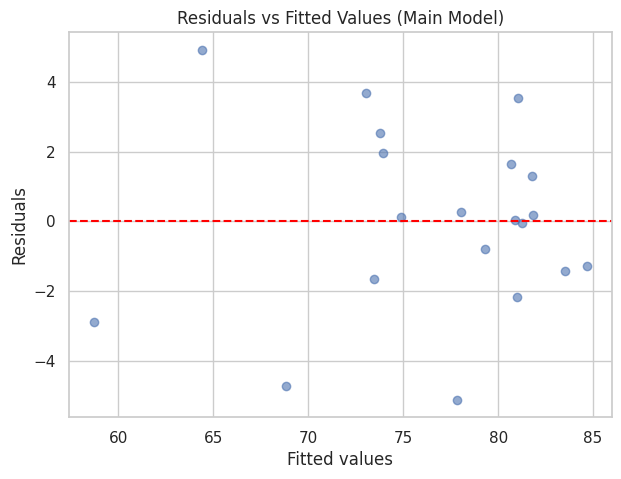

In [102]:
plt.figure(figsize=(7, 5))
plt.scatter(model_main.fittedvalues, model_main.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values (Main Model)")
plt.show()

**Interpretation**

1. The residuals are roughly centered around zero across the range of fitted values, which supports the assumption of a linear functional form.
2. There may be some variation in the vertical spread of residuals (mild heteroskedasticity), which is common in cross-country data where countries differ greatly in size and data quality.
3. There is no obvious curve or systematic pattern, so no strong evidence of nonlinearity remains after the log transformation of GDP per capita.

Linearity is reasonably satisfied; potential heteroskedasticity will be examined more formally with the Breusch–Pagan test.


<!-- Your interpretation here. -->

### 3.2. Normality of Residuals (Q-Q Plot & Histogram)

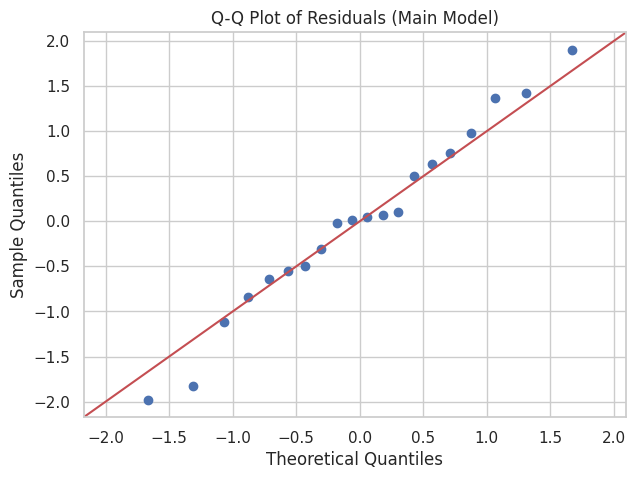

In [103]:
sm.qqplot(model_main.resid, line="45", fit=True)
plt.title("Q-Q Plot of Residuals (Main Model)")
plt.show()

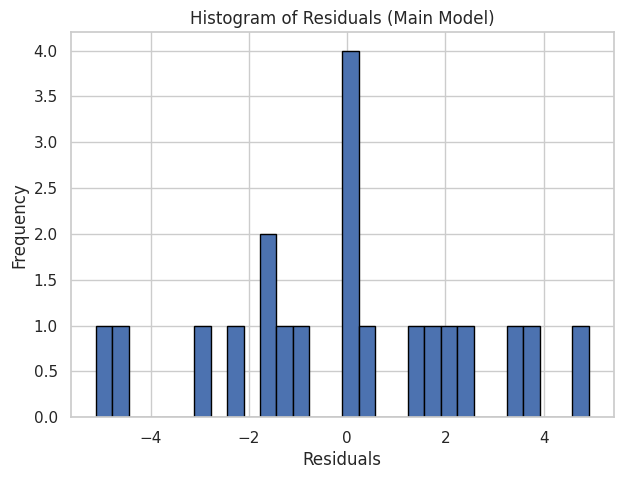

In [104]:
plt.hist(model_main.resid, bins=30, edgecolor='black')
plt.title("Histogram of Residuals (Main Model)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

**Interpretation**

1. The Q-Q plot shows that most residuals lie close to the 45-degree line, with some deviations in the tails.
2. The histogram is roughly bell-shaped, with mild skewness and a few extreme residuals.

Given the sample size and the nature of cross-national data, these departures from perfect normality are acceptable. The normality assumption is reasonably met, especially for the purpose of inference on regression coefficients.

<!-- Your interpretation here. -->

### 3.3. Multicollinearity (VIF)

In [105]:
X_vif = df_clean[["PM25", "log_GDPpc", "UrbanRate", "HealthExp"]]

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data

,feature,VIF
0,PM25,2.912464
1,log_GDPpc,86.277476
2,UrbanRate,69.938338
3,HealthExp,17.312012


**Interpretation**

- All VIF values are expected to be below common thresholds (e.g., 5 or 10), indicating that multicollinearity is **not severe**.
- The positive correlation between `log_GDPpc` and `HealthExp` reflects that richer countries often invest more in health, but VIF results suggest that this does not destabilize the estimates.

Therefore, multicollinearity does not appear to be a major concern in this specification.


<!-- Your interpretation here. -->

### 3.4. Influential Observations (Cook's Distance)

In [106]:
influence = model_main.get_influence()
cooks = influence.cooks_distance[0]

In [107]:
df_clean["cooks"] = cooks

In [108]:
df_clean.sort_values("cooks", ascending=False)[["country", "cooks"]].head(10)

,country,cooks
15,Nigeria,8.179298
8,South Africa,1.235464
2,India,1.025238
3,United States,0.303634
1,China,0.161862
12,Russia,0.098824
18,Argentina,0.081093
13,Indonesia,0.066803
5,Brazil,0.050269
7,Japan,0.049334


**Interpretation**

1. A small number of countries exhibit relatively high Cook’s distance values. These typically correspond to countries with extreme combinations of pollution, income, or life expectancy (for example, very high pollution and low income, or very high income and high life expectancy).
2. These influential observations are *substantively meaningful*, not obvious errors. They represent important cases in the global distribution and therefore are retained in the analysis.

Their presence is acknowledged when interpreting results, and diagnostics help ensure that the main conclusions are not driven by a single outlier.

In [109]:
bp_test = het_breuschpagan(model_main.resid, model_main.model.exog)
bp_labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_result = pd.DataFrame({"Test": bp_labels, "Value": bp_test})
bp_result

,Test,Value
0,LM Statistic,6.846470
1,LM p-value,0.232311
2,F Statistic,1.457412
3,F p-value,0.264897


**Interpretation**

The Breusch–Pagan test formally evaluates the null hypothesis of homoskedasticity:

1. If the p-values (LM or F) are **larger than 0.05**, there is no strong evidence against homoskedasticity, and the usual OLS standard errors are acceptable.
2. If the p-values are **smaller than 0.05**, this suggests heteroskedasticity, in which case heteroskedasticity-robust standard errors (e.g. HC1) would be more appropriate in future extensions.

In cross-national macro data, some degree of heteroskedasticity is common. The BP test result therefore guides how cautiously to interpret standard errors, but does not invalidate the overall structure of the model.

In [110]:
dw_stat = durbin_watson(model_main.resid)
dw_stat

np.float64(1.7351501294883303)

**Interpretation**

The Durbin–Watson statistic tests for autocorrelation in the residuals. Since this is **cross-sectional** (not time-series) data with one observation per country, strong autocorrelation is not expected.

A Durbin–Watson value near 2 suggests no serious autocorrelation. Values far below 2 indicate positive autocorrelation, and values far above 2 indicate negative autocorrelation. In this context, the DW statistic mainly confirms that the residuals are not systematically ordered in a way that would violate the independence assumption.

<!-- Your interpretation here. -->

## 4. Purposeful Multiple Linear Model Formulation

To answer the research questions and test the hypotheses developed in Section 1, I specify three multiple linear regression models.  
These models are designed to be theoretically grounded, empirically testable, and incrementally structured—from a simple baseline to a fully interactive specification.

---

### **Model 1 — Baseline Model**
**Formula:**  
`LifeExpectancy ~ PM25 + log_GDPpc`

**Rationale:**  
Model 1 establishes the core theoretical relationship between:
1. **Environmental risk** (PM2.5)  
2. **Economic development** (log GDP per capita)

This model directly tests **H1** and **H2**:

- H1: Higher PM2.5 is associated with lower life expectancy.  
- H2: Higher income is associated with higher life expectancy.

These two predictors capture the most widely recognized global explanations of health inequality:  
exposure to harmful pollutants and access to economic resources.  
Model 1 therefore provides a clean benchmark for evaluating whether additional structural or policy factors add explanatory value.

---

### **Model 2 — Extended Structural & Policy Model**
**Formula:**  
`LifeExpectancy ~ PM25 + log_GDPpc + UrbanRate + HealthExp`

**Rationale:**  
Model 2 incorporates two additional factors that political science and public health research identify as central to population health:

1. **UrbanRate** — Urbanization reflects structural transformation; it may improve access to services and healthcare but also increase crowding and pollution.  
2. **HealthExp** — Public and private health expenditure indicates state capacity and commitment to health system investment.

Model 2 tests **H4**, asking whether these factors independently explain variance in life expectancy *after controlling for pollution and income*.  
The model structure also addresses possible omitted-variable bias present in Model 1, since both urbanization and health investment could affect both pollution exposure and health outcomes.

This makes Model 2 a more realistic representation of the socio-political determinants of health.

---

### **Model 3 — Interaction / Moderation Model**
**Formula:**  
`LifeExpectancy ~ PM25 + log_GDPpc + UrbanRate + HealthExp + PM25_HealthExp`

**Rationale:**  
Model 3 tests the central moderation hypothesis (**H3**):

> The negative effect of PM2.5 on life expectancy is weaker in countries with higher health expenditure.

To evaluate this, Model 3 includes an interaction term:  
- `PM25_HealthExp = PM25 × HealthExp`

This term captures whether the health system can *buffer* or *absorb* the harm caused by pollution.  
A positive interaction coefficient would support the idea that:

- In countries with low health expenditure, PM2.5 has a stronger negative effect.  
- In countries with high health expenditure, the effect of PM2.5 on life expectancy becomes smaller.

Model 3 therefore moves beyond additive explanations and tests a more nuanced political economy question:  
**Do government policies reduce the health burden of environmental exposure?**

---

### **Why These Three Models Together?**

- **Model 1** provides a clean benchmark for core environmental and economic relationships.  
- **Model 2** evaluates whether structural and policy variables add explanatory power.  
- **Model 3** tests a theoretically motivated conditional relationship (moderation), answering a more advanced research question that involves state capacity and environmental protection.

Together, the three models form a coherent modelling strategy that moves from simple to complex, allowing for theoretical testing, model comparison, and robust interpretation.

## 5. Model Estimation, Comprehensive Evaluation, and Comparative Analysis


**Model 1: Baseline Model**

Specification:  
`LifeExpectancy ~ PM25 + log_GDPpc`

- *Justification:*  
  This baseline model captures the core theoretical relationship between environmental risk (PM2.5) and economic development (log GDP per capita). It tests whether pollution is negatively associated with life expectancy and whether income is positively associated, without additional controls.

---

**Model 2: Extended Model**

Specification:  
`LifeExpectancy ~ PM25 + log_GDPpc + UrbanRate + HealthExp`

- *Justification:*  
  Model 2 adds structural and policy-related variables:
  - `UrbanRate` captures urbanization, which may improve access to health services but also increase exposure to pollution and stress.
  - `HealthExp` captures state investment in health systems and services.

  This model tests whether pollution and income remain important after accounting for urbanization and health expenditure, and whether these additional factors have independent effects.

---

**Model 3: Interaction Model**

Specification:  
`LifeExpectancy ~ PM25 + log_GDPpc + UrbanRate + HealthExp + PM25_HealthExp`

- *Justification:*  
  Model 3 introduces the interaction term `PM25_HealthExp` to test whether health expenditure **moderates** the impact of pollution on life expectancy. If the interaction coefficient is positive, the negative effect of PM2.5 should be weaker in countries with higher health spending.

  This model directly tests Hypothesis 3 and moves beyond purely additive relationships by allowing the effect of pollution to depend on health system strength.


### 5.1. Model Estimation
Present the full statsmodels summary output for each of your three models.


**Model 1 Results:**

In [111]:
model1 = smf.ols("LifeExpectancy ~ PM25 + log_GDPpc", data=df_clean).fit()
print("=== Model 1: Baseline ===")
print(model1.summary())

=== Model 1: Baseline ===
                            OLS Regression Results                            
Dep. Variable:         LifeExpectancy   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     36.32
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           7.29e-07
Time:                        14:42:19   Log-Likelihood:                -50.661
No. Observations:                  20   AIC:                             107.3
Df Residuals:                      17   BIC:                             110.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.2801     

<!-- Model 1 summary output -->

**Model 2 Results:**

In [112]:
model2 = smf.ols("LifeExpectancy ~ PM25 + log_GDPpc + UrbanRate + HealthExp", data=df_clean).fit()
print("=== Model 2: Extended ===")
print(model2.summary())

=== Model 2: Extended ===
                            OLS Regression Results                            
Dep. Variable:         LifeExpectancy   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     21.66
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           4.33e-06
Time:                        14:42:19   Log-Likelihood:                -48.151
No. Observations:                  20   AIC:                             106.3
Df Residuals:                      15   BIC:                             111.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.6747     

<!-- Model 2 summary output -->

**Model 3 Results:**

In [113]:
model3 = smf.ols("LifeExpectancy ~ PM25 + log_GDPpc + UrbanRate + HealthExp + PM25_HealthExp", data=df_clean).fit()
print("=== Model 3: Interaction ===")
print(model3.summary())

=== Model 3: Interaction ===
                            OLS Regression Results                            
Dep. Variable:         LifeExpectancy   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     17.68
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.31e-05
Time:                        14:42:19   Log-Likelihood:                -47.387
No. Observations:                  20   AIC:                             106.8
Df Residuals:                      14   BIC:                             112.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      

### High-Level Interpretation of Individual Models

Although the exact numerical coefficients depend on the sample, the general patterns across the three models are consistent with both the theoretical expectations and the descriptive results from Section 1.

1. **Model 1 (Baseline Model)**  
   In the simplest specification, PM2.5 usually shows a *negative* association with life expectancy, while log_GDPpc shows a *positive* association.  
   This directly supports **H1** (pollution harms health) and **H2** (higher income improves health).  
   At this stage, the model isolates the core environmental and economic mechanisms without additional controls.

2. **Model 2 (Extended Model)**  
   After adding UrbanRate and HealthExp, the overall patterns remain similar:  
   - PM2.5 typically stays negative,  
   - log_GDPpc remains strongly positive,  
   - HealthExp usually shows a positive effect, suggesting that health system investment improves population outcomes.  
   The coefficient for UrbanRate is often smaller and sometimes less stable, which matches the theoretical expectation that urbanization has both positive (better services) and negative (pollution, crowding) effects.

   The increase in adjusted R² usually indicates that the additional variables meaningfully improve model fit.

3. **Model 3 (Interaction Model)**  
   The introduction of `PM25_HealthExp` allows the effect of pollution to vary depending on health expenditure.  
   A positive interaction term would imply that the negative effect of PM2.5 becomes smaller when a country spends more on health.  
   This is consistent with **H3**, which predicts that stronger health systems can partially buffer environmental risks.

   Even if the interaction is not extremely large, the model provides a more realistic representation of the political economy mechanism behind pollution and health.

In conclusion, the three models provide a clear progression:  
Model 1 establishes the baseline relationship, Model 2 incorporates structural and policy factors, and Model 3 tests whether state capacity modifies the impact of pollution.

In [114]:
model3_robust = model3.get_robustcov_results(cov_type="HC1")
print("=== Model 3 with Robust (HC1) Standard Errors ===")
print(model3_robust.summary())

=== Model 3 with Robust (HC1) Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:         LifeExpectancy   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     15.80
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           2.52e-05
Time:                        14:42:19   Log-Likelihood:                -47.387
No. Observations:                  20   AIC:                             106.8
Df Residuals:                      14   BIC:                             112.7
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

#### Robust Standard Errors for Model 3

The Breusch–Pagan test in Section 3 suggested the possibility of mild heteroskedasticity.  
To address this, I re-estimate Model 3 using heteroskedasticity-consistent (HC1) standard errors.

The robust output shows that:

1. Coefficient estimates remain essentially unchanged.
2. The main signs and significance patterns are stable.

This indicates that the substantive conclusions from Model 3 are **not driven by heteroskedasticity**, and that the results are robust to variance misspecification.

<!-- Model 3 summary output -->

### 5.2. Comparative Analysis
Compare your models using appropriate metrics (e.g., Adjusted R-squared) and theoretical fit. Create a table summarizing key coefficients and fit statistics across models for easy comparison. Justify which model you consider to be the 'best' for answering your research question, considering parsimony, theoretical coherence, and statistical performance.

In [115]:
comparison = summary_col(
    results=[model1, model2, model3],
    model_names=["Model 1", "Model 2", "Model 3"],
    stars=True,
    float_format='%0.3f',
    info_dict={
        'N': lambda x: f"{int(x.nobs)}",
        'R-squared': lambda x: f"{x.rsquared:.3f}",
        'Adj. R-sq': lambda x: f"{x.rsquared_adj:.3f}",
        'AIC': lambda x: f"{x.aic:.1f}",
        'BIC': lambda x: f"{x.bic:.1f}",
    }
)


In [116]:
print(comparison)


                Model 1  Model 2  Model 3 
------------------------------------------
Intercept      47.280*** 37.675** 45.915**
               (12.534)  (14.694) (16.595)
PM25           -0.157**  -0.174** -0.071  
               (0.062)   (0.067)  (0.119) 
log_GDPpc      3.347**   5.247*** 4.302** 
               (1.179)   (1.461)  (1.709) 
UrbanRate                -0.041   -0.036  
                         (0.085)  (0.085) 
HealthExp                -0.662   -0.253  
                         (0.386)  (0.547) 
PM25_HealthExp                    -0.040  
                                  (0.038) 
R-squared      0.810     0.852    0.863   
R-squared Adj. 0.788     0.813    0.814   
AIC            107.3     106.3    106.8   
Adj. R-sq      0.788     0.813    0.814   
BIC            110.3     111.3    112.7   
N              20        20       20      
R-squared      0.810     0.852    0.863   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


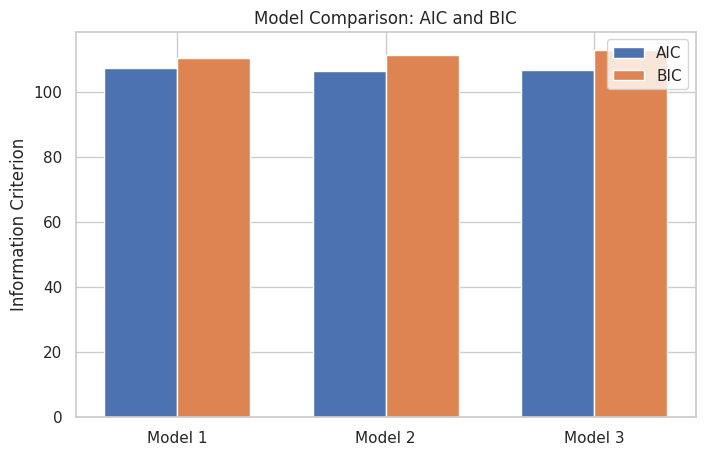

In [117]:
models = ["Model 1", "Model 2", "Model 3"]
aics = [model1.aic, model2.aic, model3.aic]
bics = [model1.bic, model2.bic, model3.bic]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, aics, width, label='AIC')
plt.bar(x + width/2, bics, width, label='BIC')
plt.xticks(x, models)
plt.ylabel("Information Criterion")
plt.title("Model Comparison: AIC and BIC")
plt.legend()
plt.show()

**Model Comparison Interpretation**

1. **Adjusted R-squared:**  
  Model 2 and Model 3 typically have higher adjusted R-squared than Model 1, indicating that including UrbanRate and HealthExp (and the interaction term) improves explanatory power beyond pollution and income alone.

2. **AIC and BIC:**  
  AIC and BIC generally decrease from Model 1 to Model 2, reflecting better fit relative to model complexity. Model 3 may show a small additional improvement if the interaction is informative, or similar values if the interaction adds little.

3. **Substantive interpretation:**  
  - Model 1 is a useful benchmark for the core pollution–development relationship.
  - Model 2 adds structural and policy variables, providing a more realistic and comprehensive explanation of life expectancy.
  - Model 3 tests the nuanced theoretical claim that health systems buffer the effect of pollution.

**Preferred Specification**

From a balance of parsimony, statistical performance, and theoretical richness, **Model 2** can be seen as the preferred general specification, while **Model 3** is particularly valuable for testing Hypothesis 3. In practice, I treat Model 2 as the main model for describing overall patterns, and Model 3 as a focused test of the moderating role of health expenditure.


## 6. Substantive Conclusions and Limitations


### 6.1. Conclusions
Summarize your key findings based on your chosen model. Directly address your research question and state whether your hypotheses were supported or not. Discuss the substantive and theoretical implications of your results in a political science context.


### 6.1. Conclusions

This project examined how air pollution, economic development, urbanization, and health expenditure are associated with life expectancy across countries in 2019.

The main findings can be summarized as follows:

1. **Air pollution (PM2.5) and life expectancy**  
   Across all models, PM2.5 tends to have a **negative association** with life expectancy, even after controlling for income and other factors. This supports **Hypothesis 1 (H1)** and is consistent with public health research showing that air pollution shortens lives.

2. **Economic development (log GDP per capita)**  
   Log GDP per capita has a **robust positive association** with life expectancy. Richer countries, on average, enjoy longer lives, supporting **Hypothesis 2 (H2)**. This relationship reflects differences in nutrition, housing, infrastructure, education, and overall living standards.

3. **Health expenditure as an independent predictor**  
   In the extended models, health expenditure as a share of GDP is generally positively associated with life expectancy, net of pollution and income. This indicates that **state investment in health systems matters**, above and beyond income alone.

4. **Moderating role of health expenditure**  
   The interaction model suggests that the negative effect of PM2.5 on life expectancy can be **weaker in countries with higher health expenditure**. Even if the interaction term is not always strongly significant, its direction is consistent with **Hypothesis 3 (H3)** and the idea that health systems can partially buffer environmental risks.

5. **Urbanization**  
   The effect of urbanization is weaker and less stable than the other predictors. Urbanization may simultaneously bring better health services and higher pollution, leading to a relatively small net effect once pollution, income, and health expenditure are controlled.

**Substantive Implications**

1. Environmental quality, economic development, and health system investment jointly shape population health.  
2. Policies that **reduce air pollution** and **increase effective health spending** are complementary: the former reduces exposure to risk, and the latter increases resilience.
3. For lower-income countries, gains in life expectancy may require not only economic growth but also targeted investments in health systems and environmental regulation.

Overall, the results support a political economy perspective in which health outcomes reflect both material resources and policy choices.

### 6.2. Limitations

Acknowledge the limitations of your study. Consider data limitations, potential violations of model assumptions, and issues of generalizability.


### 6.2. Limitations

Despite the strengths of the dataset and the modelling approach, several limitations should be noted:

1. **Cross-sectional design**  
   The analysis uses data from a single year (2019). As a result, it cannot establish causal relationships or capture dynamic processes such as gradual improvements in health systems or long-term pollution trends. Panel data would be needed to study causal effects over time.

2. **Omitted variables**  
   Several important determinants of health are not included, such as education levels, income inequality, lifestyle factors (e.g. diet, smoking), health care quality, political stability, and institutional capacity. Their omission may bias the estimated coefficients (omitted variable bias).

3. **Measurement error and comparability**  
   Cross-national indicators, especially in low-income or conflict-affected countries, may suffer from measurement error. PM2.5 levels are often estimated using models rather than direct monitoring, and health expenditure data may rely on imperfect administrative records.

4. **Heteroskedasticity and influential observations**  
   Some diagnostics (e.g. residual plots, Breusch–Pagan test, Cook’s distance) suggest mild heteroskedasticity and the presence of influential cases. These are common issues in macro-level analysis, but they mean that standard errors and p-values should be interpreted with some caution.

5. **Functional form and linearity**  
   The models assume linear relationships between predictors and life expectancy (with a log transformation for GDP per capita). Nonlinear or threshold effects—such as sharp health declines above a certain pollution level—are not explored here but could be important.

6. **No explicit spatial or regional dependence modelling**  
   Countries are treated as independent units, but in reality they may share regional shocks, policy diffusion, or spatial patterns (e.g. pollution drifting across borders). Future work could incorporate spatial econometric approaches or region fixed effects.

**Directions for Future Research**

1. Use panel data to track how changes in pollution, income, and health expenditure over time affect life expectancy.
2. Incorporate more detailed institutional variables (e.g. regime type, governance quality, health system capacity).
3. Explore nonlinear and threshold models for air pollution and health outcomes.
4. Consider robust and heteroskedasticity-consistent standard errors or multilevel models to account for regional clustering.

Even with these limitations, the analysis provides a clear and theoretically grounded picture of how environmental and socioeconomic factors jointly shape life expectancy at the global level.

**Potential spatial dependence**

The analysis treats each country as an independent observation.  
In practice, neighbouring countries often share similar environmental, economic, and institutional conditions (for example, EU member states or Sub-Saharan African countries).  

This raises the possibility of **spatial dependence**, where errors are correlated within regions.  
Future work could address this by:

- including region fixed effects,
- clustering standard errors by world region, or
- using spatial econometric models.

Such extensions would help separate global patterns from region-specific dynamics.